In [3]:
import numpy as np  # import numpy package (abbreviation stands for Numerical Python)
import matplotlib.pyplot as plt  # we plot graphs with this library

from matplotlib import cm
import matplotlib as mpl
from numpy.linalg import *
%matplotlib inline

In [35]:
R = 8.314

def populations(T, dH, dS):
    K = np.exp(-dH/(R * T) + dS / R)
    return 1/(1 + K), K/(1+K)

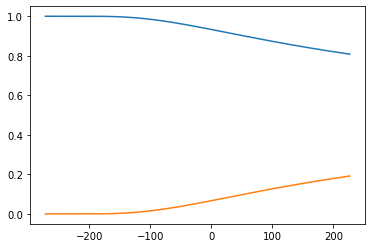

In [69]:
T = np.linspace(1, 500, 300)

pop = populations(T, 5.98209e3, 0)

plt.plot(T  - 273, pop[0])
plt.plot(T - 273, pop[1])



In [28]:
populations(25 + 273.15, 5.98209e3)

(0.917834546027615, 0.08216545397238494)